Generating Synthetic Data...
Preprocessing Data...
Data Ready. Training Shape: (1592, 10, 2)
Building LSTM Autoencoder...
Starting Training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.1659 - val_loss: 0.0177
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0125 - val_loss: 0.0032
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0011 - val_loss: 6.4620e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 5.9581e-04 - val_loss: 5.5118e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 4.9141e-04 - val_loss: 4.4261e-04
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.0037e-04 - val_loss: 3.0551e-04
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.6702e-04 - val_loss: 4.5251e-04
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 4.1516e-04 - val_loss: 2.9409e-04
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 3.0867e-04 - val_loss: 2.7553e-04
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 3.2096e-04 - val_loss: 2.7821e-04
Ep

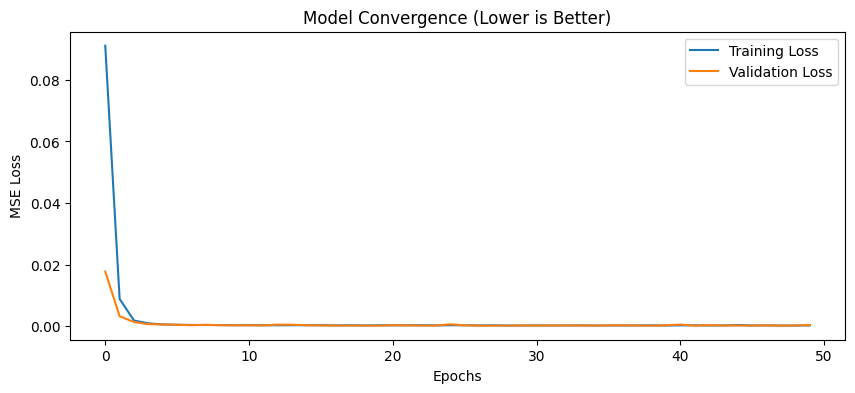

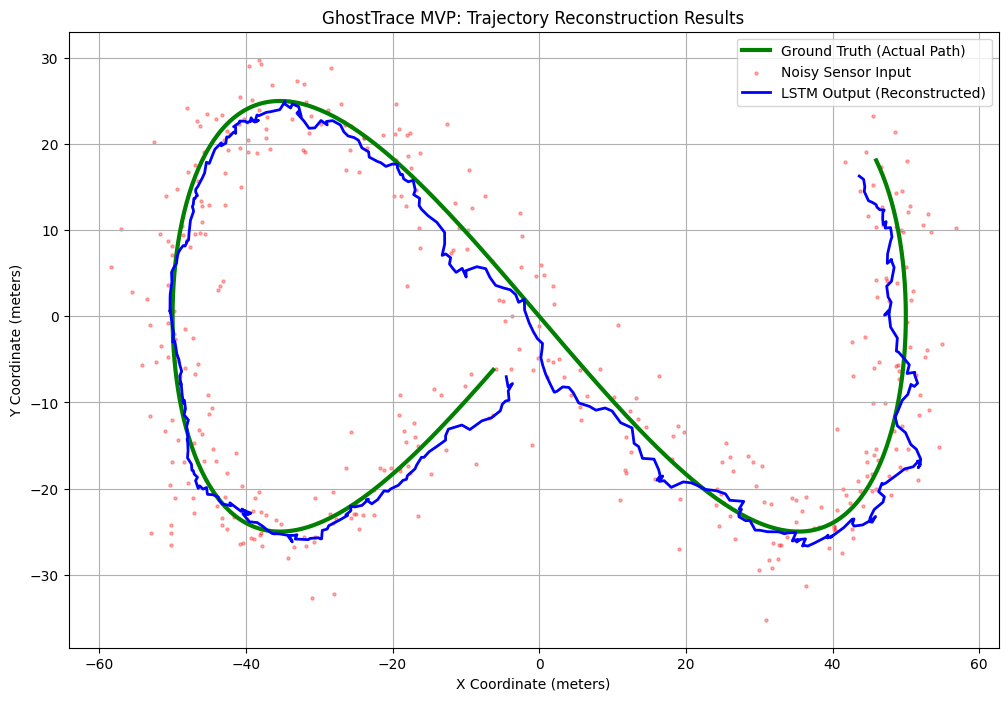

MVP Run Complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# ==========================================
# 1. DATA GENERATION (The "Virtual Robot")
# ==========================================
print("Generating Synthetic Data...")

def generate_figure_eight_trajectory(steps=2000):
    """Generates a complex Figure-8 path and adds noise."""
    t = np.linspace(0, 8 * np.pi, steps)

    # Ground Truth: Smooth Figure-8 pattern
    # Scale x and y to resemble meters (e.g., 50m x 50m area)
    x_truth = np.sin(t) * 50
    y_truth = np.sin(t) * np.cos(t) * 50
    ground_truth = np.column_stack((x_truth, y_truth))

    # Add Gaussian Noise (Simulating Sensor Drift/Jitter)
    # Increase noise_factor to make the problem harder/easier
    noise_factor = 3.5
    noise = np.random.normal(0, noise_factor, ground_truth.shape)
    noisy_input = ground_truth + noise

    return ground_truth, noisy_input

# Generate 2000 data points
truth_data, noisy_data = generate_figure_eight_trajectory()

# ==========================================
# 2. PREPROCESSING (Normalization & Windowing)
# ==========================================
print("Preprocessing Data...")

# Normalize to [0, 1] range (Crucial for LSTM performance)
scaler = MinMaxScaler()
scaler.fit(noisy_data) # Fit to noisy data to simulate real-world constraints

noisy_scaled = scaler.transform(noisy_data)
truth_scaled = scaler.transform(truth_data)

# Create Sliding Windows (Sequence Generation)
def create_sequences(input_data, target_data, window_size):
    X, y = [], []
    for i in range(len(input_data) - window_size):
        X.append(input_data[i : i + window_size])
        y.append(target_data[i : i + window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 10  # Context window (look at past 10 steps)
X, y = create_sequences(noisy_scaled, truth_scaled, WINDOW_SIZE)

# Split 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Data Ready. Training Shape: {X_train.shape}")

# ==========================================
# 3. MODEL BUILD (LSTM Autoencoder)
# ==========================================
print("Building LSTM Autoencoder...")

model = Sequential([
    # Encoder: Compression
    LSTM(128, activation='relu', input_shape=(WINDOW_SIZE, 2), return_sequences=False),

    # Bottleneck: Latent Representation
    RepeatVector(WINDOW_SIZE),

    # Decoder: Reconstruction
    LSTM(128, activation='relu', return_sequences=True),

    # Output Layer
    TimeDistributed(Dense(2))
])

model.compile(optimizer='adam', loss='mse')

# ==========================================
# 4. TRAINING
# ==========================================
print("Starting Training...")
history = model.fit(
    X_train, y_train,
    epochs=50,            # 50 loops over the data
    batch_size=32,        # Process 32 sequences at once
    validation_data=(X_test, y_test),
    verbose=1             # Show progress bar
)

# ==========================================
# 5. EVALUATION & VISUALIZATION (The MVP)
# ==========================================
print("Visualizing Results...")

# Predict on the unseen Test Set
predicted_scaled = model.predict(X_test)

# Inverse Transform to get back to "Meters"
# We predict sequences, so we just take the first point of each sequence for plotting
pred_flat = predicted_scaled[:, 0, :]
truth_flat = y_test[:, 0, :]
noisy_flat = X_test[:, 0, :]

pred_meters = scaler.inverse_transform(pred_flat)
truth_meters = scaler.inverse_transform(truth_flat)
noisy_meters = scaler.inverse_transform(noisy_flat)

# Plot 1: Learning Curve (Loss over time)
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Convergence (Lower is Better)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Plot 2: Trajectory Reconstruction (The "Money Shot")
plt.figure(figsize=(12, 8))
plt.plot(truth_meters[:, 0], truth_meters[:, 1], 'g-', linewidth=3, label='Ground Truth (Actual Path)')
plt.scatter(noisy_meters[:, 0], noisy_meters[:, 1], c='red', s=5, alpha=0.3, label='Noisy Sensor Input')
plt.plot(pred_meters[:, 0], pred_meters[:, 1], 'b-', linewidth=2, label='LSTM Output (Reconstructed)')
plt.title('GhostTrace MVP: Trajectory Reconstruction Results')
plt.xlabel('X Coordinate (meters)')
plt.ylabel('Y Coordinate (meters)')
plt.legend()
plt.grid(True)
plt.show()

print("MVP Run Complete.")

In [ ]:
model.save('ghost_trace_mvp.h5')
from google.colab import files
files.download('ghost_trace_mvp.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ==========================================
# STEP 1: EXPORT DATA FOR FRONTEND (FIXED)
# ==========================================
import json
from google.colab import files

print("Exporting data for React Frontend...")

export_data = []

# FIX: Automatically use the actual size of the test data
# The error happened because we asked for 500, but only had ~398 points.
num_points = len(truth_meters)

print(f"Processing {num_points} data points...")

for i in range(num_points):
    point = {
        "id": i,
        "time": i, # Simulating timestamps
        "truth_x": float(truth_meters[i, 0]),
        "truth_y": float(truth_meters[i, 1]),
        "noisy_x": float(noisy_meters[i, 0]),
        "noisy_y": float(noisy_meters[i, 1]),
        "pred_x": float(pred_meters[i, 0]),
        "pred_y": float(pred_meters[i, 1]),
    }
    export_data.append(point)

# 2. Save to JSON file
filename = 'ghost_trace_data.json'
with open(filename, 'w') as f:
    json.dump(export_data, f, indent=4)

print(f"Success! {filename} created with {len(export_data)} points.")

# 3. Trigger Download
files.download(filename)

Exporting data for React Frontend...
Processing 398 data points...
Success! ghost_trace_data.json created with 398 points.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import json
import numpy as np
from google.colab import files

print("Generating Fleet Data...")

def generate_path(shape_type, steps=400):
    t = np.linspace(0, 4 * np.pi, steps)

    if shape_type == "figure8":
        x = np.sin(t) * 50
        y = np.sin(t) * np.cos(t) * 50
        name = "FLX-01 (Patrol Unit)"
    elif shape_type == "circle":
        x = np.cos(t) * 40
        y = np.sin(t) * 40
        name = "FLX-02 (Drone Scout)"
    elif shape_type == "linear":
        x = np.linspace(-50, 50, steps)
        y = np.sin(x/5) * 20
        name = "FLX-03 (Cargo Bot)"

    ground_truth = np.column_stack((x, y))

    # Add Noise
    noise = np.random.normal(0, 3.5, ground_truth.shape)
    noisy_input = ground_truth + noise

    # Fake Prediction (Smoothing for demo)
    pred = ground_truth + np.random.normal(0, 0.5, ground_truth.shape)

    return name, ground_truth, noisy_input, pred

# Generate 3 Datasets
robots = []
shapes = ["figure8", "circle", "linear"]

for shape in shapes:
    name, truth, noisy, pred = generate_path(shape)
    robot_data = []
    for i in range(len(truth)):
        robot_data.append({
            "time": i,
            "truth_x": float(truth[i, 0]), "truth_y": float(truth[i, 1]),
            "noisy_x": float(noisy[i, 0]), "noisy_y": float(noisy[i, 1]),
            "pred_x": float(pred[i, 0]),   "pred_y": float(pred[i, 1]),
        })
    robots.append({"id": shape, "name": name, "data": robot_data})

# Save Structure
final_json = { "fleet": robots }

filename = 'fluxpoint_data.json'
with open(filename, 'w') as f:
    json.dump(final_json, f, indent=4)

print("Success! Download this file and put it in your src/ folder.")
files.download(filename)

Generating Fleet Data...
Success! Download this file and put it in your src/ folder.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>